In [1]:
import sys
from typing import List, Tuple, Set
import heapq

import numpy as np
import pandas as pd

sys.path.append('../..')
from utils import set_seed, plot_gantt

# Set random seed for reproducibility
set_seed(42)

In [2]:
# Load the scheduling data
schedules_df = pd.read_csv('../../data/schedules.csv')
processing_times = schedules_df['processing_time'].values
release_dates = schedules_df['release_date'].values
n_jobs = len(schedules_df)
print(f"Loaded {n_jobs} jobs")
schedules_df.head()

Loaded 100 jobs


,processing_time,release_date
0,62,0
1,47,1
2,66,2
3,88,4
4,44,18


In [3]:
class BranchAndMemorize:
    """
    A class to solve single-machine scheduling with release dates using Branch-and-Memorize.
    Minimizes TOTAL COMPLETION TIME (sum of completion times), not makespan.

    Attributes:
        p (np.ndarray): Processing times for each job.
        r (np.ndarray): Release dates for each job.
        n (int): Number of jobs.
        best_total_completion (float): The best total completion time found.
        best_sequence (List[int] or None): The sequence that achieves the best objective.
        nodes_explored (int): Number of nodes explored in the search tree.
        state_cache (Dict): Cache for memoization to avoid redundant computation.
    """

    def __init__(self, processing_times: np.ndarray, release_dates: np.ndarray):
        """
        Initializes the BranchAndMemorize instance.

        Args:
            processing_times (np.ndarray): Array of processing times for each job.
            release_dates (np.ndarray): Array of release dates for each job.
        """
        self.p = processing_times
        self.r = release_dates
        self.n = len(processing_times)
        self.best_total_completion = float('inf')
        self.best_sequence = None
        self.nodes_explored = 0

        # Memorization: Cache to store best value for each state
        # Key: (current_time, frozenset of remaining jobs)
        # Value: best total completion time seen for this state
        self.state_cache = {}

    def lower_bound(self, current_time: float, total_completion_so_far: float,
                   remaining: Set[int]) -> float:
        """
        Computes a lower bound using preemptive SRPT relaxation.

        Args:
            current_time (float): Current time in the schedule.
            total_completion_so_far (float): Sum of completion times of scheduled jobs.
            remaining (Set[int]): Set of remaining job indices.

        Returns:
            float: Lower bound on total completion time.
        """
        if not remaining:
            return total_completion_so_far

        # SRPT (Shortest Remaining Processing Time) - preemptive relaxation
        # This gives the tightest lower bound for 1|r_j|sum C_j
        jobs_data = [(self.r[j], self.p[j], j) for j in remaining]
        jobs_data.sort()  # Sort by release date

        t = current_time
        total_comp = total_completion_so_far
        job_queue = []  # Min-heap: (remaining_time, job_id)

        i = 0
        while job_queue or i < len(jobs_data):
            # Add all newly released jobs to queue
            while i < len(jobs_data) and jobs_data[i][0] <= t:
                heapq.heappush(job_queue, (jobs_data[i][1], jobs_data[i][2]))
                i += 1

            if not job_queue:
                # Jump to next release time
                if i < len(jobs_data):
                    t = jobs_data[i][0]
                continue

            # Process job with the shortest remaining time
            p_remain, job_id = heapq.heappop(job_queue)

            # Check if preemption occurs
            if i < len(jobs_data) and t + p_remain > jobs_data[i][0]:
                # Preempt: do partial work until next release
                work_done = jobs_data[i][0] - t
                t = jobs_data[i][0]
                heapq.heappush(job_queue, (p_remain - work_done, job_id))
            else:
                # Complete the job
                t += p_remain
                total_comp += t

        return total_comp

    def branch_and_bound(self) -> Tuple[List[int], float, int]:
        """
        Performs branch-and-bound search with memorization.

        Returns:
            Tuple[List[int], float, int]: Best sequence, total completion time, nodes explored.
        """
        priority_queue = []
        self.nodes_explored = 0

        # Initial node: (lower_bound, total_completion_so_far, current_time, sequence, remaining_jobs)
        initial_lb = self.lower_bound(0, 0, set(range(self.n)))
        heapq.heappush(priority_queue, (
            initial_lb,
            0.0,  # total completion time so far
            0.0,  # current time
            tuple(),  # sequence
            frozenset(range(self.n))  # remaining jobs
        ))

        while priority_queue:
            lower_bound_value, total_completion, current_time, sequence, remaining_jobs = heapq.heappop(priority_queue)
            self.nodes_explored += 1

            # Prune by lower bound
            if lower_bound_value >= self.best_total_completion:
                continue

            # Memorization Check: Have we seen this state before with better value?
            state_key = (current_time, remaining_jobs)
            if state_key in self.state_cache:
                if total_completion >= self.state_cache[state_key]:
                    continue  # This path is dominated

            # Update Cache: Store best value for this state
            self.state_cache[state_key] = total_completion

            # Complete solution found
            if not remaining_jobs:
                if total_completion < self.best_total_completion:
                    self.best_total_completion = total_completion
                    self.best_sequence = list(sequence)
                continue

            # Branch: try scheduling each remaining job
            remaining_set = set(remaining_jobs)
            for job in remaining_set:
                # Calculate new state
                start_time = max(self.r[job], current_time)  # Respects release date
                completion_time = start_time + self.p[job]  # Job completes fully
                new_total_completion = total_completion + completion_time
                new_remaining = remaining_set - {job}
                new_sequence = sequence + (job,)

                # Compute lower bound for new state
                new_lower_bound = self.lower_bound(completion_time, new_total_completion, new_remaining)

                # Only add to queue if not pruned
                if new_lower_bound < self.best_total_completion:
                    heapq.heappush(priority_queue, (
                        new_lower_bound,
                        new_total_completion,
                        completion_time,
                        new_sequence,
                        frozenset(new_remaining)
                    ))

        return self.best_sequence, self.best_total_completion, self.nodes_explored


def solve(processing_times: np.ndarray, release_dates: np.ndarray) -> Tuple[List[int], float, int]:
    """
    Solves the single-machine scheduling problem (1|r_j|sum C_j) using Branch-and-Memorize.

    Args:
        processing_times (np.ndarray): Array of processing times for each job.
        release_dates (np.ndarray): Array of release dates for each job.

    Returns:
        Tuple[List[int], float, int]: Best sequence, total completion time, and nodes explored.
    """
    solver = BranchAndMemorize(processing_times, release_dates)
    best_sequence, best_value, nodes = solver.branch_and_bound()
    return best_sequence, best_value, nodes

best_seq, best_value, nodes = solve(processing_times, release_dates)
print("Best sequence:", best_seq)
print("Total Completion Time (∑C_j):", best_value)
print("Nodes explored:", nodes)

Best sequence: [1, 8, 13, 14, 19, 23, 18, 26, 35, 37, 38, 44, 49, 33, 16, 56, 62, 52, 74, 63, 79, 45, 84, 95, 92, 69, 28, 30, 15, 24, 83, 85, 88, 10, 11, 46, 60, 51, 94, 43, 57, 93, 29, 77, 4, 5, 21, 99, 61, 80, 42, 66, 72, 32, 98, 22, 76, 78, 90, 25, 41, 36, 39, 12, 96, 97, 17, 50, 58, 87, 27, 48, 68, 70, 81, 0, 89, 9, 53, 2, 40, 7, 64, 34, 75, 55, 86, 59, 91, 67, 47, 54, 65, 20, 82, 3, 71, 6, 73, 31]
Total Completion Time (∑C_j): 179550.0
Nodes explored: 22911


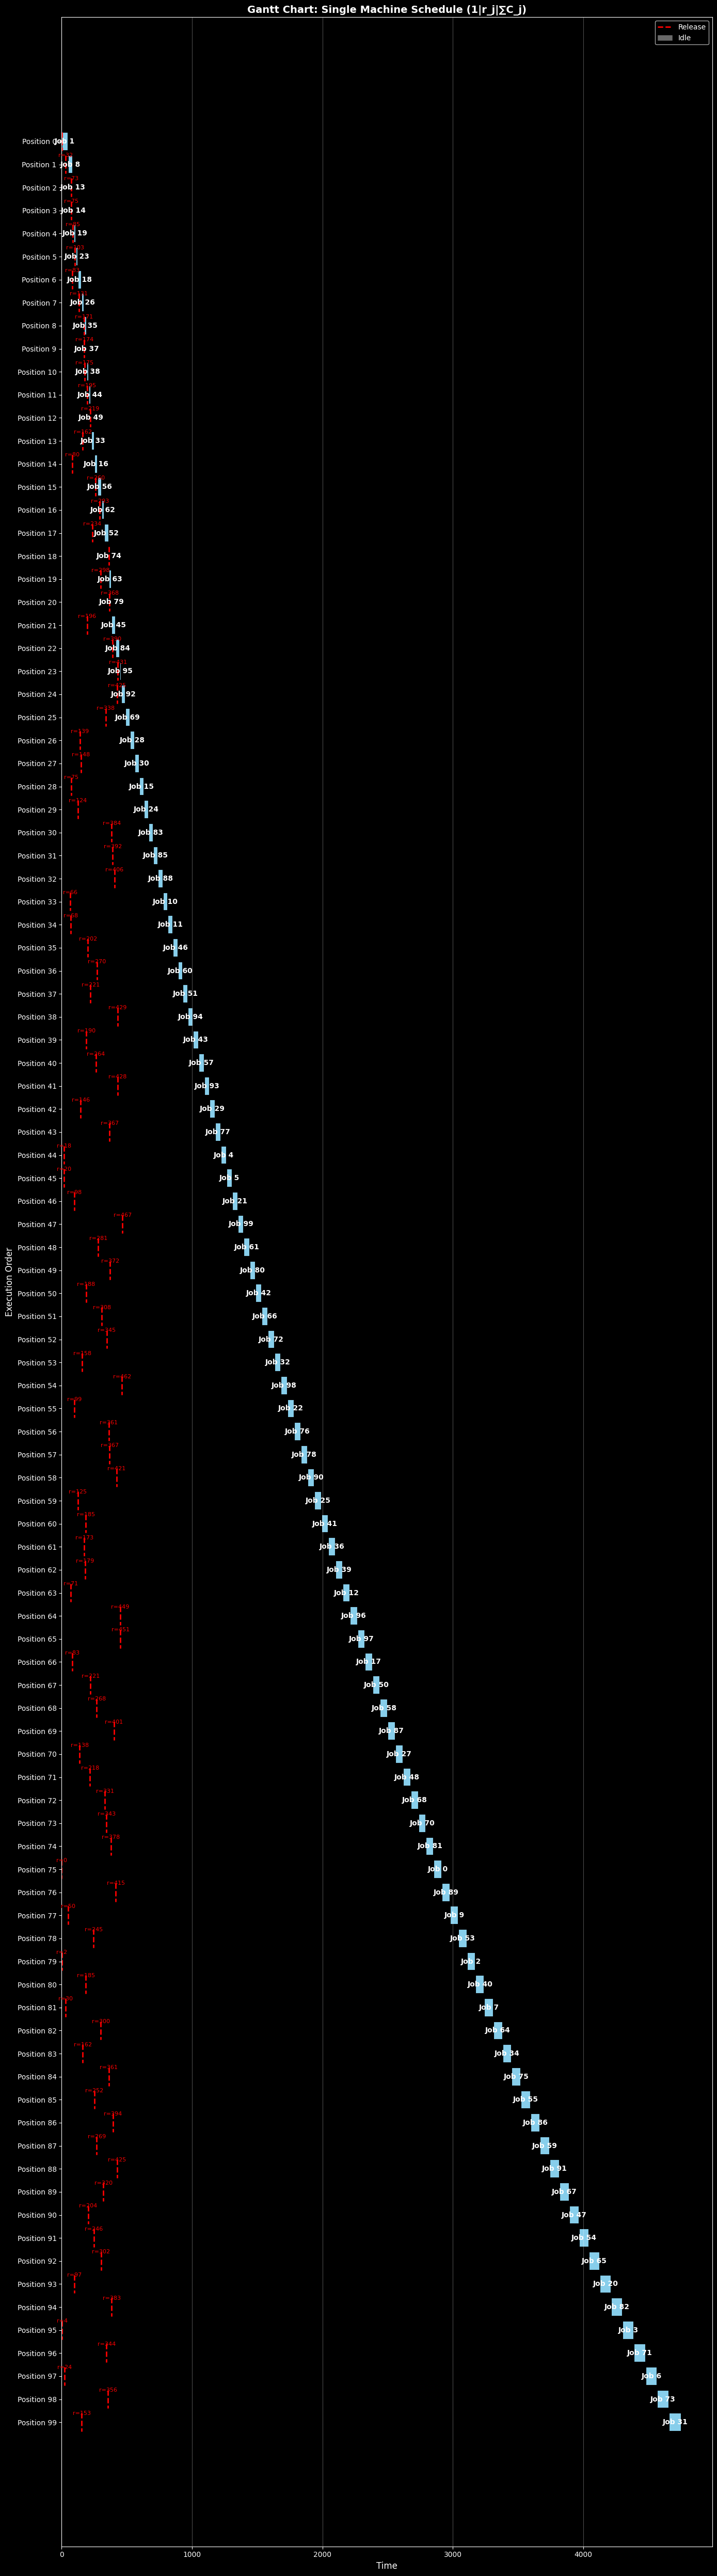

In [4]:
# Visualize the best schedule as a Gantt chart
plot_gantt(best_seq, processing_times, release_dates)